### 1. Setup and Imports

In [1]:
# --- IMPORTS ---
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from google.colab import drive
import copy

# --- DRIVE & PATHS ---
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/MVTec_Anomaly_Detection'
CHOSEN_CATEGORY = 'bottle' # A categoria que já baixamos

# Caminho para o dataset salvo no seu Drive
dataset_root = os.path.join(project_path, 'datasets', CHOSEN_CATEGORY)
train_dir = os.path.join(dataset_root, 'train')
test_dir = os.path.join(dataset_root, 'test')

# --- CONFIGURAÇÕES DO MODELO E TREINO ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
IMG_SIZE = 256
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
EPOCHS = 200 # Número máximo de épocas, mas o Early Stopping pode parar antes

print(f"Usando o dispositivo: {DEVICE}")
print(f"Caminho do dataset: {dataset_root}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usando o dispositivo: cuda
Caminho do dataset: /content/drive/MyDrive/MVTec_Anomaly_Detection/datasets/bottle


### 2. DataLoaders

In [2]:
# --- TRANSFORMAÇÕES ---
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- DATASETS E DATALOADERS ---

# Carrega o dataset de treino completo (apenas imagens 'good')
full_train_dataset = datasets.ImageFolder(
    root=train_dir,
    transform=data_transforms
)

# Dividimos o dataset de treino em 90% para treino e 10% para validação
train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_subset, val_subset = torch.utils.data.random_split(full_train_dataset, [train_size, val_size])

print(f"Dataset de treino original: {len(full_train_dataset)} imagens")
print(f"Novo dataset de treino: {len(train_subset)} imagens")
print(f"Novo dataset de validação: {len(val_subset)} imagens")

# O dataset de teste continua o mesmo
test_dataset = datasets.ImageFolder(
    root=test_dir,
    transform=data_transforms
)

# Cria os três DataLoaders
train_loader = DataLoader(dataset=train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nImagens de teste (todas): {len(test_dataset)}")

Dataset de treino original: 209 imagens
Novo dataset de treino: 188 imagens
Novo dataset de validação: 21 imagens

Imagens de teste (todas): 83


### 3. Data Visualization

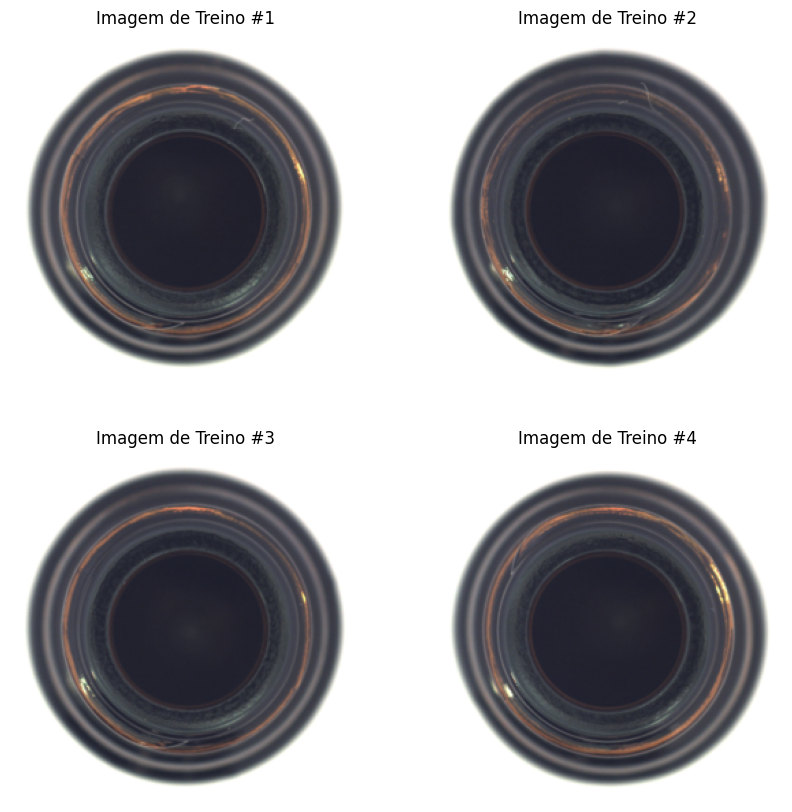

In [3]:
# Pega um lote de imagens de treino
images, _ = next(iter(train_loader))

# Plota as primeiras 4 imagens do lote
plt.figure(figsize=(10, 10))
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    # Converte o tensor para uma imagem numpy e ajusta os canais
    img = images[i].permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f"Imagem de Treino #{i+1}")
    plt.axis("off")
plt.show()

### 4. Model Definition

In [4]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        # Decoder
        self.t_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(16, 3, kernel_size=2, stride=2)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool1(x)
        x = torch.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.relu(self.conv3(x))
        x = self.pool3(x)
        x = torch.relu(self.t_conv1(x))
        x = torch.relu(self.t_conv2(x))
        x = torch.sigmoid(self.t_conv3(x))
        return x

# Instancia o modelo e imprime a arquitetura
model = ConvAutoencoder().to(DEVICE)
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv3): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


### 5. Loop Setup

In [5]:
# --- FERRAMENTAS E PARÂMETROS DE TREINAMENTO ---
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
training_history = []
PATIENCE_LIMIT = 5 # Número de épocas a esperar sem melhora antes de parar

print(f"Iniciando o treinamento com Early Stopping (Paciência = {PATIENCE_LIMIT})...")

# --- LÓGICA DO EARLY STOPPING ---
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None

# --- LOOP DE TREINAMENTO ---
for epoch in range(EPOCHS):
    # --- FASE DE TREINO ---
    model.train()
    train_epoch_loss = 0.0
    for data in train_loader:
        images, _ = data; images = images.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
    avg_train_loss = train_epoch_loss / len(train_loader)

    # --- FASE DE VALIDAÇÃO ---
    model.eval()
    val_epoch_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            images, _ = data; images = images.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, images)
            val_epoch_loss += loss.item()
    avg_val_loss = val_epoch_loss / len(val_loader)

    # Guarda o histórico
    history_log = {"epoch": epoch + 1, "train_loss": avg_train_loss, "val_loss": avg_val_loss}
    training_history.append(history_log)
    print(f"Época [{epoch+1}/{EPOCHS}], Perda de Treino: {avg_train_loss:.6f}, Perda de Validação: {avg_val_loss:.6f}")

    # --- VERIFICAÇÃO DO EARLY STOPPING ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        best_model_state = copy.deepcopy(model.state_dict()) # Salva o estado do melhor modelo
        print(f"  -> Perda de validação melhorou. Salvando o estado do modelo.")
    else:
        patience_counter += 1
        print(f"  -> Perda de validação não melhorou. Paciência: {patience_counter}/{PATIENCE_LIMIT}")

    if patience_counter >= PATIENCE_LIMIT:
        print("\nEarly stopping ativado! O treinamento foi interrompido.")
        break

print("\nTreinamento concluído!")

Iniciando o treinamento com Early Stopping (Paciência = 5)...
Época [1/200], Perda de Treino: 0.133586, Perda de Validação: 0.130761
  -> Perda de validação melhorou. Salvando o estado do modelo.
Época [2/200], Perda de Treino: 0.122058, Perda de Validação: 0.110787
  -> Perda de validação melhorou. Salvando o estado do modelo.
Época [3/200], Perda de Treino: 0.100215, Perda de Validação: 0.087094
  -> Perda de validação melhorou. Salvando o estado do modelo.
Época [4/200], Perda de Treino: 0.075157, Perda de Validação: 0.061636
  -> Perda de validação melhorou. Salvando o estado do modelo.
Época [5/200], Perda de Treino: 0.053284, Perda de Validação: 0.044689
  -> Perda de validação melhorou. Salvando o estado do modelo.
Época [6/200], Perda de Treino: 0.037411, Perda de Validação: 0.028849
  -> Perda de validação melhorou. Salvando o estado do modelo.
Época [7/200], Perda de Treino: 0.024336, Perda de Validação: 0.020109
  -> Perda de validação melhorou. Salvando o estado do modelo.


### 6. Exporting Files

In [8]:
import os
import json

# --- SALVAR HISTÓRICO EM JSON ---
json_log_file = os.path.join(project_path, f'{CHOSEN_CATEGORY}_pytorch_history.json')
print(f"Salvando histórico de treinamento em: {json_log_file}")
with open(json_log_file, 'w') as f:
    json.dump(training_history, f, indent=4)
print("Histórico salvo com sucesso.")

# --- SALVAR O MELHOR MODELO TREINADO ---
if best_model_state:
    model_save_path = os.path.join(project_path, f'{CHOSEN_CATEGORY}_autoencoder_best.pth')
    print(f"Salvando o melhor modelo em: {model_save_path}")
    torch.save(best_model_state, model_save_path)
    print("Melhor modelo salvo com sucesso.")
else:
    print("Nenhum modelo foi salvo pois o treinamento não produziu um 'melhor estado'.")

Salvando histórico de treinamento em: /content/drive/MyDrive/MVTec_Anomaly_Detection/bottle_pytorch_history.json
Histórico salvo com sucesso.
Salvando o melhor modelo em: /content/drive/MyDrive/MVTec_Anomaly_Detection/bottle_autoencoder_best.pth
Melhor modelo salvo com sucesso.
